In [79]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
from sympy.utilities.lambdify import lambdastr
from scipy.optimize import fsolve
import numpy as np
from CDPMv2_animation import animate as ani
%matplotlib inline
init_printing(True)

In [219]:
# Constants
# If this is changed the angle solution will not work correctly
workspace_width = 2.8956
middle = workspace_width/2

plate_width = 0.133
plate_height = 0.0665

rod_length = 0.5
rod_radius = 0.00635

mass_of_plate = 0.23
mass_of_rod = 0.07

cable_K = 10000.0
cable_C = 10.0 # Get in damping ratio
rod_k = 10000.0
rod_c = 5.0

inertia_of_plate = (plate_width**2 + plate_height**2) * (mass_of_plate/12.0)
inertia_of_rod = (mass_of_rod/12)*(3*rod_radius**2 + rod_length**2)

In [236]:
workspace_width = 10.4
middle = workspace_width/2

# Seconds to run the Simulation
# This number will be multiplied by 30 to give a ratio of 30pts/s
runtime = 20

plate_width = 0.5
plate_height = 0.3

rod_length = 2.91
rod_radius = 0.02
e_offset = 1.60675

mass_of_plate = 10
mass_of_rod = 2

cable_K = 10000.0
cable_C = 0.7 # Get in damping ratio
rod_k = 1000.0
rod_c = 5.0

inertia_of_plate = (plate_width**2 + plate_height**2) * (mass_of_plate/12.0)
inertia_of_rod = (mass_of_rod/12)*(3*rod_radius**2 + rod_length**2)

In [221]:
# Create the frames
A = me.ReferenceFrame('A')
# B = me.ReferenceFrame('B')
# C = me.ReferenceFrame('C')

# Create the symbols
# x, z, e, theta, beta = me.dynamicsymbols('x z e theta beta')
x_dot, z_dot, e_dot = me.dynamicsymbols('x_dot z_dot e_dot')
theta_dot, beta_dot = me.dynamicsymbols('theta_dot beta_dot')
H, a, b, M, m, g, k, t = sympy.symbols('H a b M m g k t')
Ip, Ir, c, r, p, kr, cr, D = sympy.symbols('Ip Ir c r p kr cr D')
L1, L2, X, Z, BETA = sympy.symbols('L1 L2 X Z BETA')

# Orient the Beta frame
# B = A.orientnew('B', 'Axis', [beta, A.y])
# C = A.orientnew('C', 'Axis', [theta, A.y])
# B.set_ang_vel(A, beta_dot * A.y)
# C.set_ang_vel(A, theta_dot * A.y)

In [222]:
for j in range(2):
    if j == 0:
        x, z, e, theta, beta = sympy.symbols('x z e theta beta')
        # Orient the Beta frame
        B = A.orientnew('B', 'Axis', [beta, A.y])
        C = A.orientnew('C', 'Axis', [theta, A.y])
        B.set_ang_vel(A, beta_dot * A.y)
        C.set_ang_vel(A, theta_dot * A.y)
    else:
        x, z, e, theta, beta = me.dynamicsymbols('x z e theta beta')
        # Orient the Beta frame
        B = A.orientnew('B', 'Axis', [beta, A.y])
        C = A.orientnew('C', 'Axis', [theta, A.y])
        B.set_ang_vel(A, beta_dot * A.y)
        C.set_ang_vel(A, theta_dot * A.y)
    # Create the origin points point
    A1 = me.Point('A1')
    A2 = me.Point('A2')

    # Set the origin points positions
    A1.set_pos(A1, 0)
    A2.set_pos(A1, H * A.x)

    # Create the plate center of Gravity
    G = me.Point('G')
    Gr = me.Point('Gr')

    # Set the COG position
    G.set_pos(A1, x*A.x + z*A.z)
    Gr.set_pos(G, e * C.z)

    # Create the attachment points
    B1 = me.Point('B1')
    B2 = me.Point('B2')

    # # Set the attachment points positions
    B1.set_pos(G, -a/2 * B.x - b/2 * B.z)
    B2.set_pos(G, a/2 * B.x - b/2 * B.z)

    # Create Rod top and Bottom points
    C1 = me.Point('C1')
    C2 = me.Point('C2')
    C1.set_pos(Gr, -D/2 * C.z)
    C2.set_pos(Gr, D/2 * C.z)

    # Create the position vectors
    a2 = A2.pos_from(A1)
    a2_x = a2 & A.x
    a2_z = a2 & A.z

    r1 = B1.pos_from(G)
    r1_x = r1 & A.x
    r1_z = r1 & A.z

    r2 = B2.pos_from(G)
    r2_x = r2 & A.x
    r2_z = r2 & A.z

    r21 = B2.pos_from(B1)
    r21_x = r21 & A.x
    r21_z = r21 & A.z

    s1 = B1.pos_from(A1)
    s2 = B2.pos_from(A2)

    # Calculating the Geometric lengths from the top corners of the plate
    Length1 = s1.magnitude()
    Length2 = s2.magnitude()

    # Creating the unit vectors pointing from the origins to the top plate points
    s1_vector = s1.normalize()
    s2_vector = s2.normalize()
    
    if j == 0:
        p = ((r21_x * x + a2_x * r1_x) * z - r21_z * x**2 +
             (r1_z * r2_x - r1_x * r2_z + a2_x * r21_z - a2_z * r2_x) * x +
             r1_x *  (a2_x * r2_z - a2_z * r2_x))
        equation_all = p.subs({H:workspace_width, a:plate_width, b:plate_height}).evalf()
        equation_all = equation_all.simplify()
        lambda_str1 = lambdastr((beta), equation_all)
        lambda_str2 = lambda_str1.replace('sin', 'np.sin')
        lambda_str3 = lambda_str2.replace('cos', 'np.cos')
        lambda_str4 = lambda_str3.replace('x', 'x_temp')
        lambda_str = lambda_str4.replace('z', 'z_temp')
        func1 = eval(lambda_str)

In [223]:
# Set velocity of origin points
A1.set_vel(A, 0)
A2.set_vel(A, 0)

# Set velocity of COG
G.set_vel(A, x_dot * A.x + z_dot * A.z)
G.set_vel(B, 0)

Gr.set_vel(C, e_dot * C.z)
Gr.v1pt_theory(G, A, C)
# Gr.v2pt_theory(G, A, C)

# Set velocity of attachment points
B1.v2pt_theory(G, A, B)
B2.v2pt_theory(G, A, B)
B1.set_vel(B,0)
B2.set_vel(B,0)

In [224]:
# Set up the kinematic differential equations
kde = [x_dot - x.diff(t),
       z_dot - z.diff(t),
       e_dot - e.diff(t),
       beta_dot - beta.diff(t),
       theta_dot - theta.diff(t)]

# Create the plate inertial tensor
I_plate = me.inertia(A, 0, Ip, 0)
inertia_plate = (I_plate, G)

# Create the rod inertial tensor
I_rod = me.inertia(A, 0, Ir, 0)
inertia_rod = (I_rod, Gr)

# Create the Rigid Bodies
Plate = me.RigidBody('Plate', G, B, M, inertia_plate)
Rod = me.RigidBody('Rod', Gr, C, m, inertia_rod)

In [225]:
def K1(Length):
    '''
    This function does not allow the spring to push on the plate
    '''
    return 1000 * (Length >= L1)

def K2(Length):
    '''
    This function does not allow the spring to push on the plate
    '''
    return 1000 * (Length >= L2)

In [226]:
def C1(Length):
    '''
    This function does not allow the damper to push on the plate
    '''
    return 10 * (Length >= L1)

def C2(Length):
    '''
    This function does not allow the damper to push on the plate
    '''
    return 10 * (Length >= L2)

In [227]:
# Creating the forces acting on the body
grav_force_plate = (G, M * g * A.z)
grav_force_rod = (Gr, m * g * A.z)

spring_force_B1 = (B1, s1_vector * K1(Length1) * (L1 - Length1))
spring_force_B2 = (B2, s2_vector * K2(Length2) * (L2 - Length2))
# spring_force_B1 = (B1, s1_vector * cable_K * (L1 - Length1))
# spring_force_B2 = (B2, s2_vector * cable_K * (L2 - Length2))

# spring_rod = (Gr, -kr * e * C.z)
spring_rod = (Gr, -kr * (e + e_offset) * C.z)
# spring_rod_on_plate = (G, kr * e * C.z)
spring_rod_on_plate = (G, kr * (e + e_offset) * C.z)

damper_rod = (Gr, -cr * e_dot * C.z)
damper_rod_on_plate = (G, cr * e_dot * C.z)

B1_velocity = x_dot*A.x + z_dot*A.z - b*beta_dot/2*B.x + a*beta_dot/2*B.z
B2_velocity = x_dot*A.x + z_dot*A.z - b*beta_dot/2*B.x - a*beta_dot/2*B.z

B1_damping = (-C1(Length1) * B1_velocity & s1_vector) * s1_vector
B2_damping = (-C2(Length2) * B2_velocity & s2_vector) * s2_vector
# B1_damping = (-cable_C * B1_velocity & s1_vector) * s1_vector
# B2_damping = (-cable_C * B2_velocity & s2_vector) * s2_vector

damp_B1 = (B1, B1_damping)
damp_B2 = (B2, B2_damping)

B_frame_damp = (B, -0.006 * beta_dot * B.y)
C_frame_damp = (C, -0.001 * theta_dot * C.y)

C_frame_spring = (C, 100 * (beta - theta) * C.y)
C_frame_spring_on_B = (B, 100 * (theta - beta) * B.y)

loads = [grav_force_plate,
         grav_force_rod,
         spring_force_B1,
         spring_force_B2,
         spring_rod,
         spring_rod_on_plate,
         damper_rod,
         damper_rod_on_plate,
         damp_B1,
         damp_B2,
         B_frame_damp,
         C_frame_damp,
         C_frame_spring,
         C_frame_spring_on_B]

In [228]:
# Setting up the coordinates, speeds, and creating KanesMethod
coordinates = [x, z, e, beta, theta]
speeds = [x_dot, z_dot, e_dot, beta_dot, theta_dot]
kane = me.KanesMethod(A, coordinates, speeds, kde)

# Creating Fr and Fr_star
fr, frstar = kane.kanes_equations(loads, [Plate, Rod])

# Creating the PyDy System
sys = System(kane)

In [229]:
## Initial Conditions
# If init_L1 and L2 are 0 they will be solved for
# If e_init is 0 it's equilibrium will be solved for
# You can put init_x = middle 
init_x = middle #- middle/2
init_z = 1.5
init_L1 = 0
init_L2 = 0
e_init = 0
init_beta = 0
init_theta = 0

In [230]:
# Linkage Geometry
z_temp = init_z
x_temp = init_x
tau_initial_guess = 0.08
if init_x == middle:
    init_beta = 0
else:
    tau_solution = fsolve(func1, tau_initial_guess)
    init_beta = (tau_solution)[0]
print(np.rad2deg(init_beta))

0.0


In [231]:
init_z

In [232]:
# Getting the correct lengths for testing
Len1 = Length1.subs({x:init_x,
                     z:init_z,
                     H:workspace_width,
                     a:plate_width,
                     b:plate_height, 
                     beta:init_beta})
Len2 = Length2.subs({x:init_x,
                     z:init_z,
                     H:workspace_width,
                     a:plate_width,
                     b:plate_height, 
                     beta:init_beta})

if init_L1 == 0:
    init_L1 = Len1
if init_L2 == 0:
    init_L2 = Len2
if e_init == 0:
    e_init = ((9.81 * mass_of_rod) / rod_k) - e_offset
print('Length 1: {}\nLength 2: {}\ne: {}'.format(init_L1,init_L2, e_init))

Length 1: 5.13078941294612
Length 2: 5.13078941294612
e: -1.58713


In [237]:
# Seconds to run the Simulation
# This number will be multiplied by 30 to give a ratio of 30pts/s
runtime = 20

# Assigning all the constants
sys.constants = {M: 10,
                 m: 2,
                 g: 9.81,
                 H: 10.4,
                 a: 0.5,
                 b: 0.3,
                 kr: rod_k,
                 cr: rod_c,
                 Ip: inertia_of_plate,
                 Ir: inertia_of_rod,
#                  L1: init_L1,
#                  L2: init_L2,
                 L1: 4.9158,
                 L2: 4.9158
                 }
sys.initial_conditions = {x:init_x,
                          z:1.52,
                          beta:init_beta,
                          e:e_init, 
                          theta:0.0}
sys.times = np.linspace(0.0, runtime, runtime * 30)
sys.generate_ode_function(generator='cython')

<function pydy.codegen.ode_function_generators.ODEFunctionGenerator._create_rhs_function.<locals>.rhs>

In [238]:
resp = sys.integrate()

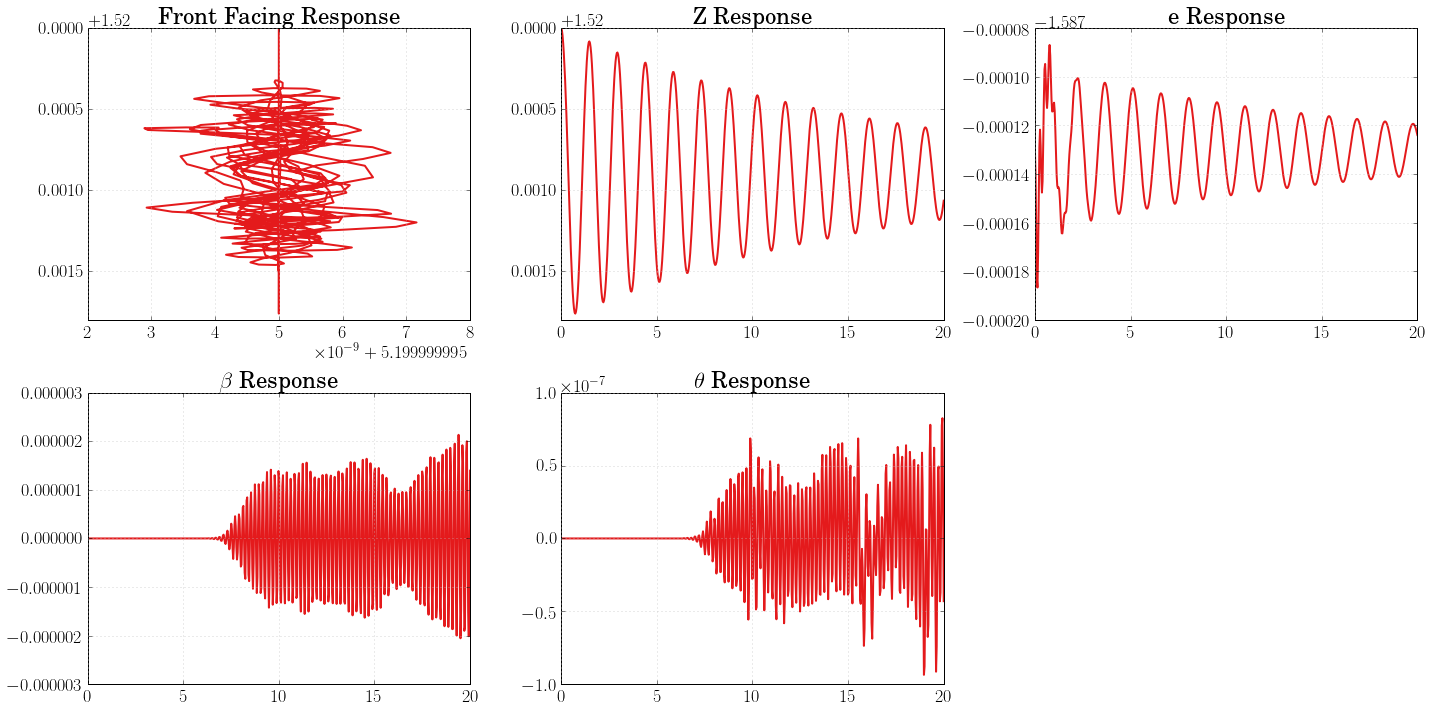

In [239]:
mpl.rcParams['savefig.dpi'] = 72
plt.figure(num=1, figsize=(20,10))
ax = plt.gca()
ax.set_aspect('equal')
plt.subplot(231)
plt.plot(resp[:,0], resp[:,1])
plt.title('Front Facing Response', fontsize=23)
plt.gca().invert_yaxis()
plt.subplot(232)
plt.plot(sys.times, resp[:,1])
plt.title('Z Response', fontsize=23)
plt.gca().invert_yaxis()
plt.subplot(233)
plt.plot(sys.times, resp[:,2])
plt.title(r'e Response', fontsize=23)
plt.subplot(234)
plt.plot(sys.times, np.rad2deg(resp[:,3]))
plt.title(r'$\beta$ Response', fontsize=23)
plt.subplot(235)
plt.plot(sys.times, np.rad2deg(resp[:,4]))
plt.title(r'$\theta$ Response', fontsize=23)
plt.tight_layout()
# plt.savefig('/Users/forrest/Desktop/testing2.pdf')

In [58]:
# plt.plot(sys.times, np.rad2deg(resp[:,3]))
# plt.title(r'$\beta$ Response')
# plt.xlim(0,1)

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270
Processing frame 300
Processing frame 330
Processing frame 360
Processing frame 390
Processing frame 420
Processing frame 450
Processing frame 480
Processing frame 510
Processing frame 540
Processing frame 570


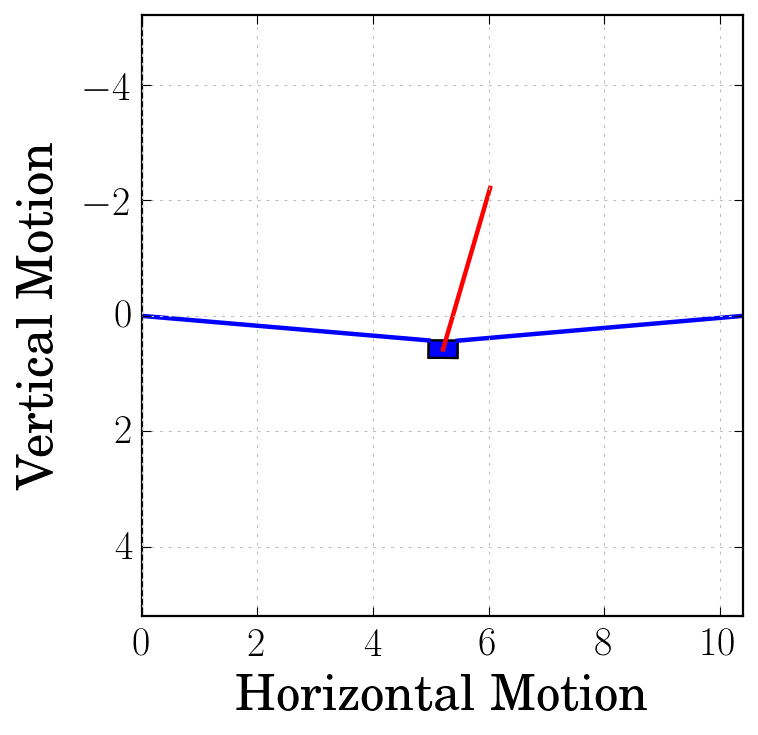

In [69]:
import numpy as np
x_resp = resp[:,0]
z_resp = resp[:,1]
e_resp = resp[:,2]
beta_resp = resp[:,3]
theta_resp = resp[:,4]

D = rod_length

# For the cables
left_point_x = (x_resp - (plate_width/2) * np.cos(beta_resp) -
                        (plate_height/2) * np.sin(beta_resp))
left_point_z = (z_resp + (plate_width/2) * np.sin(beta_resp) -
                        (plate_height/2) * np.cos(beta_resp))

right_point_x = (x_resp + (plate_width/2) * np.cos(beta_resp) -
                         (plate_height/2) * np.sin(beta_resp))
right_point_z = (z_resp - (plate_width/2) * np.sin(beta_resp) -
                         (plate_height/2) * np.cos(beta_resp))


# For the Rod
rod_top_x = ((-D/2 + e_resp)*np.sin(theta_resp) + x_resp)
rod_top_z = ((-D/2 + e_resp)*np.cos(theta_resp) + z_resp)

rod_bottom_x = ((D/2 + e_resp)*np.sin(theta_resp) + x_resp)
rod_bottom_z = ((D/2 + e_resp)*np.cos(theta_resp) + z_resp)

import matplotlib.animation as animation
import matplotlib.pyplot as plt
# Change some plot properties to make the video work and look better
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot(111, aspect='equal')
plt.ylim(workspace_width/2,-workspace_width/2)
plt.xlim(0,workspace_width)
plt.xlabel('Horizontal Motion', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Motion', fontsize=22, weight='bold', labelpad=10)
# plt.axes().set_aspect('equal')

leftcable, = plt.plot([],[], linewidth=2, linestyle = '-',
                      label='leftcable', color='b')
rightcable, = plt.plot([],[], linewidth=2, linestyle = '-',
                       label='rightcable', color='b')
rodline, = plt.plot([],[], linewidth=2, linestyle = '-',
                      label='rodline', color='r')
patch = patches.Rectangle((0, 0), 0, 0, angle=0)

# centerG, = plt.plot([],[], 'ro', label='Center of Gravity')
# rod,    = plt.plot([],[], linewidth=6, linestyle = '-', label='rod',
#                    color='r')

def init():
    """ Initialize the lines in the plot """
    leftcable.set_data([], [])
    rightcable.set_data([], [])
    ax.add_patch(patch)
    rodline.set_data([], [])

    return leftcable, rightcable, patch, rodline,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))

    rightcable.set_data([0, left_point_x[i]], [0, left_point_z[i]])
    leftcable.set_data([workspace_width, right_point_x[i]], [0, right_point_z[i]])
    patch.set_width(plate_width)
    patch.set_height(plate_height)
    patch.set_xy([left_point_x[i], left_point_z[i]])
#     This is negative because the patch coordinate system defines clockwise as postitive
    patch._angle = np.rad2deg(-beta_resp[i])
    rodline.set_data([rod_top_x[i], rod_bottom_x[i]], [rod_top_z[i], rod_bottom_z[i]])

    return leftcable, rightcable, patch, rodline,

ani_un = animation.FuncAnimation(fig, animate_un, interval = 30,
        frames = 30*runtime, blit = True, init_func = init)

ani_un.save('{}.mp4'.format('/Users/forrest/Desktop/Rod_CDPM_static'), bitrate = 2500, fps = 30)